### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision 
import torch.nn.functional as F  
import torchvision.datasets as datasets  
import torchvision.transforms as transforms 
from torch import optim  
from torch import nn  
from torch.utils.data import DataLoader  
from tqdm import tqdm  
from torchmetrics import F1Score, ConfusionMatrix

### Training and Testing Dataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
in_channels = 1
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 15

In [4]:
torch.manual_seed(0)
train_dataset = datasets.MNIST(root='dataset/',train = True, transform=transforms.ToTensor(),download=True)
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_dataset = datasets.MNIST(root='dataset/',train = False, transform=transforms.ToTensor(),download=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

In [5]:
class CNN(nn.Module):  
    def __init__(self,input_channels = 1,num_classes = 10,dropout = 0.0):  
        #super initialization of the parent class
        super(CNN,self).__init__()   

        self.conv1 = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.fc1 = nn.Linear(16*7*7,64)
        self.fc2 = nn.Linear(64,num_classes)
        self.dropout = nn.Dropout(p = dropout)
        
    def forward(self,x):   
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0],-1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Initialize Network

In [6]:
torch.manual_seed(0)
model = CNN(input_channels = 1,num_classes = 10,dropout = 0.1).to(device)

#cost function
criterion = nn.CrossEntropyLoss()
#optimization algorithm
optimizer = optim.RMSprop(model.parameters(),lr = learning_rate)

### Train Network

In [7]:
torch.manual_seed(0)
loss_after_epoch = []
for epoch in range(num_epochs):
    running_loss = 0
    for batch_idx,(data,targets) in enumerate(tqdm(train_loader)):
        data = data.to(device=device)
        targets = targets.to(device = device)
        
        
        #forward
        scores = model(data)
        loss = criterion(scores,targets)
        
        #backward
        optimizer.zero_grad()  
        loss.backward()
        
        #gradient descent
        optimizer.step() 
        
        running_loss += loss.item()
    loss_after_epoch.append(running_loss/len(train_loader))

100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:10<00:00, 88.34it/s]


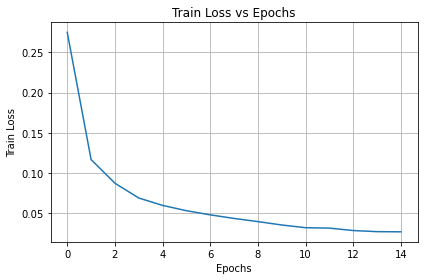

In [8]:
#Plot training loss against epochs
#plt.style.use('fivethirtyeight')
x = np.arange(0,num_epochs)
plt.plot(x,loss_after_epoch)
plt.grid(True)
plt.title("Train Loss vs Epochs")
plt.xlabel('Epochs')
plt.ylabel('Train Loss') 
plt.tight_layout()
plt.show()

### Evaluation

In [9]:
def evaluation(loader, model):
    model.eval()
    
    num_correct = 0
    num_samples = 0
    predicted = torch.Tensor()
    actual = torch.Tensor()
    
    with torch.no_grad():
        for x, y in loader:
            
            x = x.to(device=device)
            y = y.to(device=device)
            actual = torch.cat((actual,y.reshape(-1)))
        

            # Forward pass
            scores = model(x)
            _, predictions = scores.max(1)
            predicted = torch.cat((predicted,predictions.reshape(-1)))
            
            #keep track of number of correctly classified samples
            num_correct += (predictions == y).sum()

            # Keep track of number of samples
            num_samples += predictions.size(0)
            
    # Check how many we got correct
    accuracy = num_correct/num_samples    
    
    predicted = predicted.type(torch.int64)
    actual = actual.type(torch.int64)
    
    cm = ConfusionMatrix(10)
    df = pd.DataFrame((cm(predicted,actual)).cpu().numpy())
    print("Confusion matrix: ")
    print(df)
    
    #summation of the prediction of all the single classes
    pre = df.sum(axis = 0)
    #summation of ground truths of every individual digit in the dataset 
    act = df.sum(axis = 1)
    
    f1 = F1Score(10)
    
    #calculate percentage of class accuracy 
    class_accuracy = []
    for i in range(num_classes):
        class_accuracy.append((df.loc[i,i]/act[i])*100)
    
    return (class_accuracy,accuracy,f1(predicted,actual))
    
train_class_per, train_class_acc, train_f1 = evaluation(train_loader,model)
test_class_per, test_class_acc, test_f1 = evaluation(test_loader,model)

Confusion matrix: 
      0     1     2     3     4     5     6     7     8     9
0  5920     0     1     0     0     0     1     0     1     0
1     0  6734     3     0     1     0     1     3     0     0
2     0     1  5954     1     0     0     0     2     0     0
3     0     0     2  6124     0     2     0     1     1     1
4     0     1     0     0  5837     0     1     1     0     2
5     2     1     0     4     0  5401    12     0     1     0
6     5     1     2     0     2     0  5907     0     1     0
7     0     8     4     2     1     0     0  6250     0     0
8     3     4     3     5     3     4     4     0  5820     5
9     2     2     0     3    26     2     1    31     1  5881
Confusion matrix: 
     0     1     2     3    4    5    6     7    8    9
0  977     0     0     0    0    0    1     1    1    0
1    0  1134     0     1    0    0    0     0    0    0
2    1     0  1024     3    1    0    0     3    0    0
3    0     0     2  1002    0    4    0     1    1    0


In [10]:
# accuracy and F1 score 
print(f"Accuracy on training set: {train_class_acc*100:.2f}")
print(f"f1 score is: {train_f1.cpu().numpy()*100:.2f}")
print(f"Accuracy on test set: {test_class_acc*100:.2f}")
print(f"f1 score is: {test_f1.cpu().numpy()*100:.2f}")

Accuracy on training set: 99.71
f1 score is: 99.71
Accuracy on test set: 99.04
f1 score is: 99.04


In [11]:
#Test and train accuracy of every class in the dataset
df_train = pd.DataFrame(np.array(train_class_per).reshape(10,1))
df_test = pd.DataFrame(np.array(test_class_per).reshape(10,1))
df = pd.concat([df_train,df_test],axis = 1)
df.columns = ['train_acc_per_digit','test_acc_per_digit']
df

,train_acc_per_digit,test_acc_per_digit
0,99.949350,99.693878
1,99.881341,99.911894
2,99.932863,99.224806
3,99.885826,99.207921
4,99.914413,99.287169
5,99.631064,99.439462
6,99.814126,98.851775
7,99.760575,98.832685
8,99.470176,98.459959
9,98.856951,97.423191


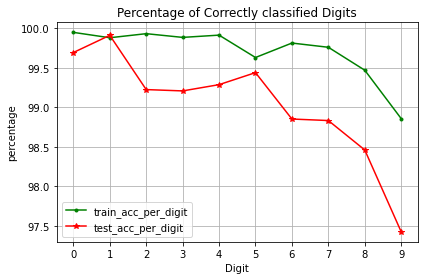

In [13]:
#plot class percentage of every digit class
x = np.arange(0,10)
plt.plot(x,np.array(train_class_per),'g',label = 'train_acc_per_digit',marker = '.')
plt.plot(x,np.array(test_class_per),'r',label = 'test_acc_per_digit',marker = '*')
plt.title('Percentage of Correctly classified Digits')
plt.xlabel('Digit')
plt.ylabel('percentage') 
plt.grid(True)  
plt.xticks(ticks=x) 
plt.tight_layout()
plt.legend()

plt.savefig("cnn_class_accuracy.png")

plt.show()